In [64]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from __future__ import print_function
from __future__ import division
import pickle

torch.manual_seed(1)

In [65]:
class LSTMSequenceLabler(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMSequenceLabler, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, dropout=0, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, 3)
        self.softmax = nn.Softmax(dim=2)
        self.loss = nn.CrossEntropyLoss(weight=torch.Tensor([1, 2, 3]))
        
    
    def get_loss(self, batch_x, batch_y):
#         print(batch_y.shape)
        batch_y = batch_y.contiguous().view(-1)
        prediction = self.forward(batch_x).view(-1, 3)
#         print(prediction.shape, batch_y.shape)
        loss = self.loss(prediction, batch_y)
        return loss
    
    def forward(self, batch_x):
        word_embeddings = self.embedding(batch_x) #outputs 50, 15, <embedding_size>
        lstm_out, _ = self.lstm(word_embeddings) #output 50, 15, <2 * hidden_size>
        linear_out = self.linear(lstm_out) #output 50, 15, 3
        softmax_out = self.softmax(linear_out) #output 50, 15, 3
        return softmax_out
    
    def set_pretrained_vectors(self, embedding_matrix, fixed = True):
        if fixed:
            self.embedding.weights = torch.Tensor(embedding_matrix)
        else:
            self.embedding.weights = torch.Tensor(embedding_matrix).requires_grad_()

In [66]:
import math

PADDING = "<PAD>"
# max sentence size
max_len = 68

EMBEDDING_DIM = 100
HIDDEN_DIM = 20

batch_size = 20

train_file_x = 'data/restaurants_train_x.txt'
train_file_y = 'data/restaurants_train_y.txt'

test_file_x = 'data/restaurants_test_x.txt'
test_file_y = 'data/restaurants_test_y.txt'

def make_list(path):
    f = open(path)
    return [x.split() for x in f]

train_x = make_list(train_file_x)
# print('max len', max(map(len, train_x)))
train_y = make_list(train_file_y)
# training_data = list(zip(train_x, train_y))
test_x = make_list(test_file_x)
test_y = make_list(test_file_y)

# print('max len', max(map(len, test_x)))

# add padding
for i in xrange(len(train_x)):
    for _ in xrange(max_len-len(train_x[i])):
        train_x[i].append('<PAD>')
        train_y[i].append(0)

for i in xrange(len(test_x)):
    for _ in xrange(max_len-len(test_x[i])):
        test_x[i].append('<PAD>')
        test_y[i].append(0)

word2id = {}
id2word = {}
for sentence in train_x:
    for word in sentence:
        word = word.lower()
        if word not in word2id:
            word2id[word] = len(word2id)
            id2word[len(word2id)-1] = word

# for unknown words, only in testing, randomly initialized
word2id['<unk>'] = len(word2id)
id2word[len(word2id)-1] = '<unk>'

## save the id2word to get the vectors
# save_file = open("id2word.pickle", "wb")
# pickle.dump(id2word, save_file)
# save_file.close()

# load the glove weights
load_file = open('embedding_matrix.pickle')
embedding_matrix = pickle.load(load_file)
load_file.close()

In [67]:
# make train data tensors
for i in xrange(len(train_x)):
    train_x[i] = map(lambda x: word2id[x.lower()], train_x[i])
    train_y[i] = map(int, train_y[i])
    
for i in xrange(len(test_x)):
    test_x[i] = map(lambda x: word2id[x.lower()] if x.lower() in word2id else word2id['<unk>'], test_x[i])
    test_y[i] = map(int, test_y[i])
train_x = torch.LongTensor(train_x)
train_y = torch.LongTensor(train_y)
test_x = torch.LongTensor(test_x)
test_y = torch.LongTensor(test_y)

# training_data = zip(train_x, train_y)

In [68]:
# accuracy calculation
def get_scores(prediction, target, label):
    pred = prediction.clone()
    tar = target.clone()
    
    pred[pred!=label] = -2
    tar[tar!=label] = -3
    
    true_positivies = torch.sum(pred==tar).tolist()
    pred[pred==label] = 1
    pred[pred!=1] = 0
    predicted_positives = torch.sum(pred).tolist()
    if predicted_positives!=0:
        precision = true_positivies / predicted_positives
    else:
        precision = 0

    pred = prediction.clone()
    tar = target.clone()

    pred[pred!=label] = 1
    pred[pred==label] = -1

    tar[tar!=label] = -2
    tar[tar==label] = 1

    false_negatives = torch.sum(tar==pred).tolist()
    
    recall = true_positivies / (false_negatives + true_positivies)

    fscore = 2 * precision * recall / (precision + recall)

    return precision, recall, fscore

In [69]:
model = LSTMSequenceLabler(len(word2id), EMBEDDING_DIM, HIDDEN_DIM)
# set the pretrained vectors for the embedding
model.set_pretrained_vectors(embedding_matrix, fixed=True)

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-4)

# to see how the precision and recall chage
precisions = []
recalls = []
fscores = []

for epoch in range(60):
    batch_id = 0
    start = 0
    end = 0
    
    loss_val = 0
    
    while(batch_id < int(math.ceil(len(training_data)/batch_size))):
        start = batch_id * batch_size
        end = min(start + batch_size, len(training_data))
        
        batch_x = train_x[start:end].permute(1,0) #shape = 68 (max_len), 15 (batch_size)
        batch_y = train_y[start:end].permute(1,0)
#         print(batch_y.shape)
        
        model.zero_grad()
        loss = model.get_loss(batch_x, batch_y)
        loss.backward()
        optimizer.step()
        loss_val += loss.tolist() * (end - start)
        batch_id += 1
    
    print('Epoch %d/20' % (epoch%20))
    if epoch%5==4:
        print("==========================================")
        print("Loss at epoch %d" % epoch, loss_val)
        print("-----------------------------------------")
        # check training accuracy in each 20 epochs
        
        ## Training
#         prediction = model(train_x.permute(dims=(1,0)))
#         prediction = prediction.argmax(dim=2)
#         target = train_y.permute(dims=(1,0))
        print(prediction.tolist())
        print("0 :",get_scores(prediction, target, 0))
        print("1 :",get_scores(prediction, target, 1))
        print("2 :",get_scores(prediction, target, 2))
        
        print("-----------------------------------------")
        
        ## Testing
        prediction = model(test_x.permute(dims=(1,0)))
        prediction = prediction.argmax(dim=2)
        target = test_y.permute(dims=(1,0))
        
        print("0 :",get_scores(prediction, target, 0))
        print("1 :",get_scores(prediction, target, 1))
        print("2 :",get_scores(prediction, target, 2))
        
        print("==========================================")
        
#         print("Saving model...")
#         torch.save(model.state_dict(), 'lstm_models/model_' + str(epoch))

Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Loss at epoch 4 1068.63473535
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0

0 : (0.980522767845248, 0.9517651622914781, 0.9659299700771695)
1 : (0.04053109713487072, 1.0, 0.07790463398253862)
2 : (0.0732899022801303, 0.11450381679389313, 0.08937437934458789)
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Loss at epoch 9 957.163847685
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0

0 : (0.9791639400047116, 0.9674641148325359, 0.9732788676692512)
1 : (0.032191069574247146, 1.0, 0.06237424547283703)
2 : (0.08780487804878048, 0.0916030534351145, 0.08966376089663759)
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Loss at epoch 14 884.911953211
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0 : (0.9787604185599668, 0.974912711754817, 0.9768327761797404)
1 : (0.03074866310160428, 1.0, 0.05966277561608301)
2 : (0.10793650793650794, 0.08651399491094147, 0.096045197740113)
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Loss at epoch 19 840.862048864
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0 : (0.9783613499625584, 0.9799301694038536, 0.9791451312797188)
1 : (0.028333333333333332, 1.0, 0.055105348460291734)
2 : (0.10843373493975904, 0.06870229007633588, 0.08411214953271028)
Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Loss at epoch 24 813.55025053
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0 : (0.9782054910840645, 0.9832147937411095, 0.9807037457434733)
1 : (0.029469548133595286, 1.0, 0.05725190839694656)
2 : (0.11274509803921569, 0.058524173027989825, 0.07705192629815745)
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Loss at epoch 29 795.685913563
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0 : (0.9780036446703113, 0.9854907539118065, 0.9817329245355938)
1 : (0.028761061946902654, 1.0, 0.05591397849462365)
2 : (0.12883435582822086, 0.05343511450381679, 0.07553956834532373)
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Loss at epoch 34 783.303625584
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

0 : (0.9777982638088654, 0.9875598086124402, 0.9826547943795357)
1 : (0.028350515463917526, 1.0, 0.055137844611528826)
2 : (0.12408759124087591, 0.043256997455470736, 0.0641509433962264)
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Loss at epoch 39 774.269149303
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

0 : (0.9776300651923815, 0.9890081469028837, 0.9832861918230908)
1 : (0.026392961876832845, 1.0, 0.051428571428571435)
2 : (0.125, 0.03816793893129771, 0.05847953216374269)
Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Loss at epoch 44 767.387516499
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

0 : (0.9775553456068228, 0.9901461269882322, 0.9838104538212469)
1 : (0.029508196721311476, 1.0, 0.057324840764331204)
2 : (0.12037037037037036, 0.03307888040712468, 0.05189620758483033)
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Loss at epoch 49 761.955715418
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0 : (0.9774779370504515, 0.9911547911547911, 0.9842688549010542)
1 : (0.025547445255474453, 1.0, 0.0498220640569395)
2 : (0.125, 0.030534351145038167, 0.049079754601226995)
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Loss at epoch 54 757.54037261
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

0 : (0.9773792541267577, 0.9923186344238976, 0.9847922896266732)
1 : (0.028688524590163935, 1.0, 0.055776892430278883)
2 : (0.13157894736842105, 0.02544529262086514, 0.042643923240938165)
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Loss at epoch 59 753.862036467
-----------------------------------------
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

0 : (0.9772466977170344, 0.9930686667528773, 0.9850941556775616)
1 : (0.02304147465437788, 1.0, 0.04504504504504504)
2 : (0.1323529411764706, 0.022900763358778626, 0.039045553145336226)


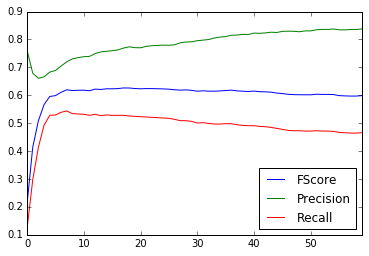

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.DataFrame({"Precision" : precisions, "Recall" : recalls, "FScore" : fscores})
data.plot.line()
plt.show()


In [90]:
# save model
torch.save(model.state_dict(), 'first_model')

In [9]:
# load model
model = LSTMSequenceLabler(len(word2id), EMBEDDING_DIM, HIDDEN_DIM)
model.load_state_dict(torch.load('first_model'))

RuntimeError: Error(s) in loading state_dict for LSTMSequenceLabler:
	While copying the parameter named "embedding.weight", whose dimensions in the model are torch.Size([2356, 20]) and whose dimensions in the checkpoint are torch.Size([2356, 5]).
	While copying the parameter named "lstm.bias_ih_l0_reverse", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.weight_hh_l0_reverse", whose dimensions in the model are torch.Size([32, 8]) and whose dimensions in the checkpoint are torch.Size([16, 4]).
	While copying the parameter named "lstm.bias_ih_l0", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.bias_hh_l0", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.bias_ih_l1", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.weight_ih_l0_reverse", whose dimensions in the model are torch.Size([32, 20]) and whose dimensions in the checkpoint are torch.Size([16, 5]).
	While copying the parameter named "lstm.bias_hh_l1_reverse", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.bias_ih_l1_reverse", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.weight_ih_l1", whose dimensions in the model are torch.Size([32, 16]) and whose dimensions in the checkpoint are torch.Size([16, 8]).
	While copying the parameter named "lstm.weight_ih_l0", whose dimensions in the model are torch.Size([32, 20]) and whose dimensions in the checkpoint are torch.Size([16, 5]).
	While copying the parameter named "lstm.weight_hh_l1_reverse", whose dimensions in the model are torch.Size([32, 8]) and whose dimensions in the checkpoint are torch.Size([16, 4]).
	While copying the parameter named "lstm.bias_hh_l0_reverse", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.bias_hh_l1", whose dimensions in the model are torch.Size([32]) and whose dimensions in the checkpoint are torch.Size([16]).
	While copying the parameter named "lstm.weight_hh_l0", whose dimensions in the model are torch.Size([32, 8]) and whose dimensions in the checkpoint are torch.Size([16, 4]).
	While copying the parameter named "lstm.weight_hh_l1", whose dimensions in the model are torch.Size([32, 8]) and whose dimensions in the checkpoint are torch.Size([16, 4]).
	While copying the parameter named "lstm.weight_ih_l1_reverse", whose dimensions in the model are torch.Size([32, 16]) and whose dimensions in the checkpoint are torch.Size([16, 8]).
	While copying the parameter named "linear.weight", whose dimensions in the model are torch.Size([1, 16]) and whose dimensions in the checkpoint are torch.Size([1, 8]).

In [112]:
import nltk.tokenize

sentence = nltk.tokenize.word_tokenize("Good service, good food")
pre_size = len(sentence)

for _ in xrange(max_len-len(sentence)):
    sentence.append('<PAD>')
        
raw_sentence = sentence[:pre_size]
sentence = torch.LongTensor(map(lambda x: word2id[x] if x in word2id else word2id['<unk>'], sentence))

print(zip(raw_sentence, model(sentence.view(max_len, 1)).tolist()[:pre_size]))

[('Good', [0.0]), ('service', [1.0]), (',', [0.0]), ('good', [0.0]), ('food', [1.0])]
